In [1]:
!pip install pygame

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pygame
import random
import numpy as np
from pygame.math import Vector2
from collections import defaultdict
import matplotlib.pyplot as plt

pygame.init()
cell_size = 20
cell_number = 20
screen = pygame.display.set_mode((cell_number * cell_size, cell_number * cell_size))
clock = pygame.time.Clock()

/home/gehna/.local/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class SNAKE:
    def __init__(self):
        self.body = [Vector2(5, 10)]
        self.direction = Vector2(1, 0)
        self.new_block = False

    def move_snake(self):
        if self.body:  # prevent crash if snake is too short
            if self.new_block:
                body_copy = self.body[:]
                body_copy.insert(0, body_copy[0] + self.direction)
                self.body = body_copy[:]
                self.new_block = False
            else:
                body_copy = self.body[:-1]
                if body_copy:
                    body_copy.insert(0, body_copy[0] + self.direction)
                else:
                    body_copy = [self.body[0] + self.direction]
                self.body = body_copy[:]
                
    def add_block(self):
        self.new_block = True

    def reset(self):
        self.__init__()

class Apple:
    def __init__(self):
        self.randomize()

    def randomize(self):
        self.pos = Vector2(random.randint(0, cell_number - 1), random.randint(0, cell_number - 1))

class Game:
    def __init__(self):
        self.snake = SNAKE()
        self.apple = Apple()

    def reset(self):
        self.__init__()

In [4]:
def get_state(game):
    head = game.snake.body[0]
    point_l = head + Vector2(-1, 0)
    point_r = head + Vector2(1, 0)
    point_u = head + Vector2(0, -1)
    point_d = head + Vector2(0, 1)

    dir_l = game.snake.direction == Vector2(-1, 0)
    dir_r = game.snake.direction == Vector2(1, 0)
    dir_u = game.snake.direction == Vector2(0, -1)
    dir_d = game.snake.direction == Vector2(0, 1)

    def danger(p):
        return (
            p.x < 0 or p.x >= cell_number or
            p.y < 0 or p.y >= cell_number or
            p in game.snake.body[1:]
        )

    state = (
        danger(head + game.snake.direction),
        danger(rotate_right(game.snake.direction)),
        danger(rotate_left(game.snake.direction)),
        dir_l, dir_r, dir_u, dir_d,
        game.apple.pos.x < head.x,
        game.apple.pos.x > head.x,
        game.apple.pos.y < head.y,
        game.apple.pos.y > head.y
    )
    return tuple(int(x) for x in state)

def rotate_right(direction):
    return Vector2(direction.y, -direction.x)

def rotate_left(direction):
    return Vector2(-direction.y, direction.x)

def move(action, direction):
    if action == 0:  # straight
        return direction
    elif action == 1:  # right
        return rotate_right(direction)
    else:  # left
        return rotate_left(direction)

In [5]:
q_table = defaultdict(lambda: [0, 0, 0])
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
alpha = 0.1
gamma = 0.9

def choose_action(state):
    if random.random() < epsilon:
        return random.randint(0, 2)
    else:
        return np.argmax(q_table[state])

def update_q(state, action, reward, next_state):
    max_future = max(q_table[next_state])
    current = q_table[state][action]
    q_table[state][action] += alpha * (reward + gamma * max_future - current)

In [6]:
episodes = 500
scores = []

for ep in range(episodes):
    game = Game()
    total_reward = 0
    done = False
    frame = 0

    while not done:
        state = get_state(game)
        action = choose_action(state)
        new_direction = move(action, game.snake.direction)
        game.snake.direction = new_direction
        game.snake.move_snake()

        reward = 0
        done = False
        head = game.snake.body[0]

        # Death
        if (head.x < 0 or head.x >= cell_number or
            head.y < 0 or head.y >= cell_number or
            head in game.snake.body[1:]):
            reward = -10
            done = True

        # Eat food
        elif head == game.apple.pos:
            reward = 10
            game.snake.add_block()
            game.apple.randomize()

        next_state = get_state(game)
        update_q(state, action, reward, next_state)
        total_reward += reward
        frame += 1

    scores.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if ep % 50 == 0:
        print(f"Episode {ep}, Score: {total_reward}, Epsilon: {epsilon:.3f}")

Episode 0, Score: 0, Epsilon: 0.995
Episode 50, Score: 0, Epsilon: 0.774
Episode 100, Score: 20, Epsilon: 0.603
Episode 150, Score: 0, Epsilon: 0.469
Episode 200, Score: 30, Epsilon: 0.365
Episode 250, Score: 30, Epsilon: 0.284
Episode 300, Score: 30, Epsilon: 0.221
Episode 350, Score: 50, Epsilon: 0.172
Episode 400, Score: 30, Epsilon: 0.134
Episode 450, Score: 200, Epsilon: 0.104


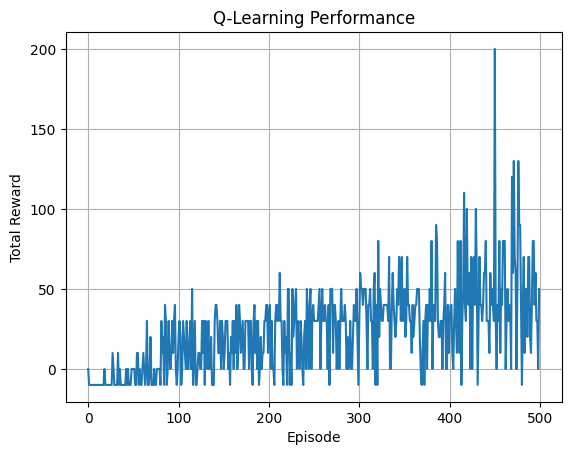

In [7]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Performance')
plt.grid()
plt.show()

In [8]:
# DQN Implementation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [10]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [12]:
input_dim = 11  # same as state vector length
output_dim = 3  # actions: [straight, right, left]

policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Target network is not trained

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

replay_buffer = ReplayBuffer()

In [13]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, output_dim - 1)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state)
        return q_values.argmax().item()

In [14]:
def train_step(batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    q_values = policy_net(states)
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
        target_q = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [15]:
episodes = 500
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
gamma = 0.9
batch_size = 64
target_update = 10
scores_dqn = []

for ep in range(episodes):
    game = Game()
    total_reward = 0
    done = False
    step = 0

    while not done:
        state = get_state(game)
        action = select_action(state, epsilon)
        new_direction = move(action, game.snake.direction)
        game.snake.direction = new_direction
        game.snake.move_snake()

        reward = 0
        head = game.snake.body[0]

        if (head.x < 0 or head.x >= cell_number or
            head.y < 0 or head.y >= cell_number or
            head in game.snake.body[1:]):
            reward = -10
            done = True

        elif head == game.apple.pos:
            reward = 10
            game.snake.add_block()
            game.apple.randomize()

        next_state = get_state(game)
        replay_buffer.push(state, action, reward, next_state, done)
        train_step(batch_size, gamma)

        total_reward += reward
        step += 1

    scores_dqn.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if ep % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if ep % 50 == 0:
        print(f"Episode {ep}, Score: {total_reward}, Epsilon: {epsilon:.3f}")

Episode 0, Score: -10, Epsilon: 0.995
Episode 50, Score: 10, Epsilon: 0.774
Episode 100, Score: -10, Epsilon: 0.603
Episode 150, Score: 20, Epsilon: 0.469
Episode 200, Score: 0, Epsilon: 0.365
Episode 250, Score: 30, Epsilon: 0.284
Episode 300, Score: 0, Epsilon: 0.221
Episode 350, Score: 30, Epsilon: 0.172
Episode 400, Score: 40, Epsilon: 0.134
Episode 450, Score: 30, Epsilon: 0.104


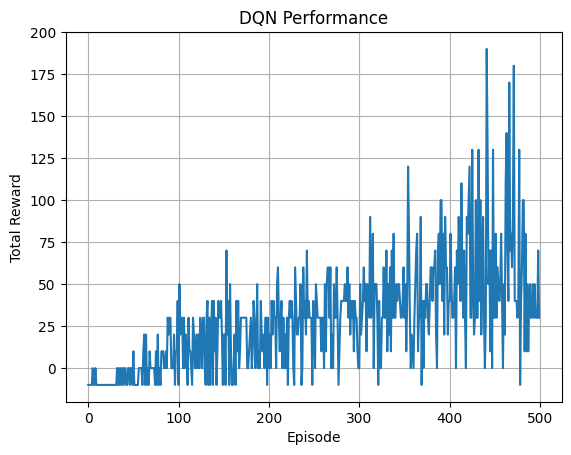

In [16]:
plt.plot(scores_dqn)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Performance')
plt.grid()
plt.show()

In [17]:
def play_with_trained_model(policy_net, episodes=1, delay=100):
    pygame.font.init()
    font = pygame.font.SysFont("consolas", 24, bold=True)

    for ep in range(episodes):
        game = Game()
        done = False
        score = 0

        while not done:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            state = get_state(game)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()

            game.snake.direction = move(action, game.snake.direction)
            game.snake.move_snake()

            head = game.snake.body[0]
            if (head.x < 0 or head.x >= cell_number or
                head.y < 0 or head.y >= cell_number or
                head in game.snake.body[1:]):
                done = True

            if head == game.apple.pos:
                game.snake.add_block()
                game.apple.randomize()
                score += 1
                
            screen.fill((10, 10, 10))  # Black background

            # Draw neon grid
            for x in range(0, cell_number * cell_size, cell_size):
                pygame.draw.line(screen, (30, 30, 30), (x, 0), (x, cell_number * cell_size))
            for y in range(0, cell_number * cell_size, cell_size):
                pygame.draw.line(screen, (30, 30, 30), (0, y), (cell_number * cell_size, y))

            # Draw snake with neon glow
            for i, block in enumerate(game.snake.body):
                color = (0, 255, 180) if i == 0 else (0, 200, 150)  # Head is brighter
                pygame.draw.rect(screen, color, pygame.Rect(
                    block.x * cell_size, block.y * cell_size, cell_size, cell_size), border_radius=4)

            # Draw glowing apple
            pygame.draw.rect(screen, (255, 240, 80), pygame.Rect(
                game.apple.pos.x * cell_size, game.apple.pos.y * cell_size, cell_size, cell_size), border_radius=6)

            # Score text
            score_text = font.render(f"Score: {score}", True, (255, 255, 255))
            screen.blit(score_text, (10, 10))

            pygame.display.update()
            pygame.time.delay(delay)

In [18]:
play_with_trained_model(policy_net, episodes=2, delay=90)